In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import time

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import simgraph.my_simgraph_06 as sg
import dataprocess.data_handler_03 as dh

# Load and group neuron spike data

In [2]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
binned_data = np.load(spikes_dp+'spikes.npy')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

In [3]:
binned_data.shape

(297, 1141, 113)

In [4]:
I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1
        
grouped_data.shape

(297, 1141, 1)

# Create training and validation datasets

In [5]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}

In [6]:
train_num = 50
val_num = 50

# # # load all the labels
# # data_path = '../../data/fe_exp/mnist-sift/'
# # lbls = np.loadtxt(data_path+'lbls.csv')

# def transform_mnistsift(fv):
#     return fv[::4]

# def get_mnist_labels(data_params):
#     return np.loadtxt(data_params['features_dp']+'lbls.csv')

# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=0)

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  slowfast
train_num =  50 , val_num =  50
number of features:  474
training data contains 25 points (50.00%) of label 1.
validation data contains 25 points (50.00%) of label 1.
train_des =  [[2.83248091 1.9573375  1.80305851 ... 2.63181782 5.0626092  1.73198915]
 [2.85622716 1.84450686 1.83374453 ... 3.59775019 4.99465513 1.81246066]
 [2.84266281 1.91707706 2.0776329  ... 2.59656143 5.06516504 1.94811893]
 ...
 [2.804281   1.92478943 1.92925155 ... 2.58050275 5.01891279 1.70074773]
 [2.78913069 1.88559127 1.96933186 ... 2.62543321 5.04550409 1.75575078]
 [2.80804682 1.86615241 1.92949975 ... 2.58304954 5.05852318 1.93327451]] 
val_des =  [[2.81228805 1.85959542 1.89799547 ... 2.66008282 5.05984354 1.78894365]
 [2.87820601 1.88902676 1.83449078 ... 3.94310379 4.9631362  1.7618444 ]
 [2.76299763 1.95418108 2.01021791 ... 2.61140656 5.06339979 1.98884845]
 ...
 [2.82420778 1.8628298  1.96258771 ... 2.64727163 5.10923338 1.71433222]
 [2.75081801 1.89080465 1.99364614 ... 2.5847

# Set parameters

In [7]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [8]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv':None, 'Dvt':2000, 'mu':30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':100, 'check_freq':10, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

In [9]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

In [10]:
# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

In [11]:
len(sg_params['edges_tt'])

625

## Fact-GLR&trace

In [12]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B, fact_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M = fact_B.T @ fact_B
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 50
Number of features for each point: 474
mu = 30
   0: eps = 1.66e-03;  train loss (E) = 649.77
  10: eps = 5.23e-03;  train loss (E) = 80.92
  20: eps = 4.12e-03;  train loss (E) = 79.33
  30: eps = 6.49e-03;  train loss (E) = 78.84
  40: eps = 5.11e-03;  train loss (E) = 78.69
  50: eps = 4.02e-03;  train loss (E) = 78.63
  60: eps = 3.17e-03;  train loss (E) = 78.59
  70: eps = 2.49e-03;  train loss (E) = 78.57
  80: eps = 3.93e-03;  train loss (E) = 78.56
  90: eps = 6.19e-03;  train loss (E) = 78.55
  99: eps = 5.73e-03;  train loss (E) = 78.54
Elapsed  time: 101.739340 sec


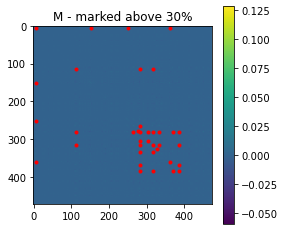

In [13]:
visualize_M(fact_M, fig_params)

In [14]:
train_num, val_num, train_data2, val_data2 = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=123)

# random parameter for edge selection and B initialization
seed = 123

# update sg_params
sg_params['train_t'] = train_data2['smpls']
sg_params['val_t'] = val_data2['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data2['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

Number of training datapoints: 50
Number of features for each point: 474
mu = 30
   0: eps = 1.66e-03;  train loss (E) = 634.96
  10: eps = 2.61e-03;  train loss (E) = 96.05
  20: eps = 4.12e-03;  train loss (E) = 94.30
  30: eps = 3.24e-03;  train loss (E) = 93.97
  40: eps = 5.11e-03;  train loss (E) = 93.84
  50: eps = 4.02e-03;  train loss (E) = 93.79
  60: eps = 3.17e-03;  train loss (E) = 93.76
  70: eps = 4.99e-03;  train loss (E) = 93.75
  80: eps = 3.93e-03;  train loss (E) = 93.74
  90: eps = 3.09e-03;  train loss (E) = 93.74
  99: eps = 2.87e-03;  train loss (E) = 93.73
Elapsed  time: 112.909806 sec


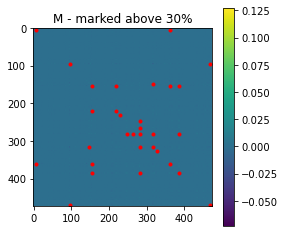

In [15]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B2, fact_stats2 = sg.fit_graph(train_data2['des'], train_data2['lbls'], sg_params, gd_opt_params, seed)
fact_M2 = fact_B2.T @ fact_B2
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(fact_M2, fig_params)

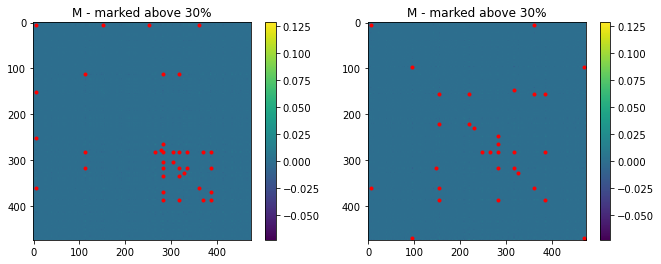

In [18]:
# unpack params
rmark_th = fig_params['rmark_th']
xloc = fig_params['xloc']
yloc = fig_params['yloc']

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.imshow(fact_M, vmin=min(np.min(fact_M), np.min(fact_M2)), vmax=max(np.max(fact_M), np.max(fact_M2)))
plt.colorbar()   
lim = (rmark_th/100) * np.max(fact_M) # marker threshold                
plt.plot(xloc[fact_M > lim],yloc[fact_M > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M - marked above {}%'.format(rmark_th))

plt.subplot(1,2,2)
plt.imshow(fact_M2, vmin=min(np.min(fact_M), np.min(fact_M2)), vmax=max(np.max(fact_M), np.max(fact_M2)))
plt.colorbar()   
lim = (rmark_th/100) * np.max(fact_M2) # marker threshold                
plt.plot(xloc[fact_M2 > lim],yloc[fact_M2 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M - marked above {}%'.format(rmark_th))
plt.savefig('image/Ms.png',dpi=300, bbox_inches = "tight")